# This is a data linking tool that is quicker to run than the marked down version. (If you want the marked down version it's on my github branch). It links stream gauge data to satellite data and generates images of water bodies according to a specified flow or water level range.

In [1]:
#Just run this box once with 'Shift'+'Enter'. It loads all the things you need to work with the data. 
import sys
import os
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.gridspec as gs
import matplotlib.pyplot as plt
import datacube
from datacube.utils import geometry 
from datacube.utils.geometry import CRS
from datacube.storage import masking
from datacube.helpers import ga_pq_fuser, write_geotiff
from digitalearthau.utils import wofs_fuser
sys.path.append('../10_Scripts/')
#import DEAPlotting, DEADataHandling
import warnings
warnings.filterwarnings('ignore', module='datacube')
%load_ext autoreload
%autoreload 2

# Enter location and generate duration curve

Barmah choke: 
lat = -35.92
lon = 145.00
buffer = 10000

Colignan:
lat = -34.56709452
lon = 142.4072101
buffer = 7000

Niemur:
lat = -35.277
lon = 144.3477
buffer = 5500

Macquarie Marshes:
lat = -30.8072
lon = 147.5149
buffer = 10000

Gunbower:
lat = -35.942574
lon = 144.46466
buffer = 10000

Walkool:
lat = -35.1356
lon = 143.6823
buffer = 10000

Murray River at Boundary Bend:
lat = -34.71966901
lon = 143.1698626
buffer = 10000

Wee Waa:
lat = -30.2033
lon = 149.4361
buffer = 10000

Yarrongbilly:
lat = -35.79
lon = 148.40138889
buffer = 6000

18 Mile Swamp:
lat = -27.49561971
lon = 153.50836409
buffer = 6000

Blue Lake QLD:
lat = -27.535
lon = 153.48916667
buffer = 6000

Text(0.5, 1.0, 'FDC log')

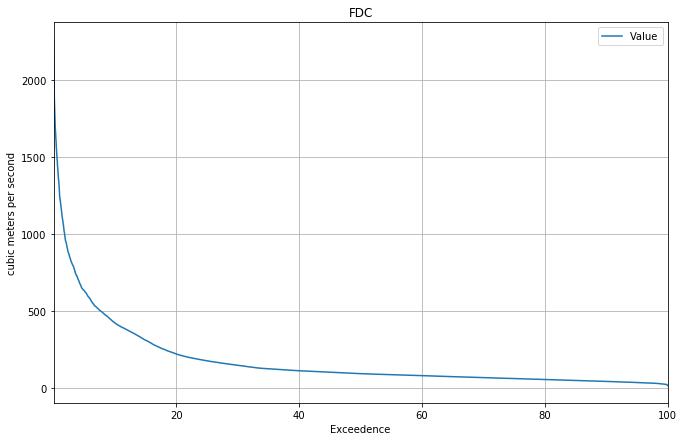

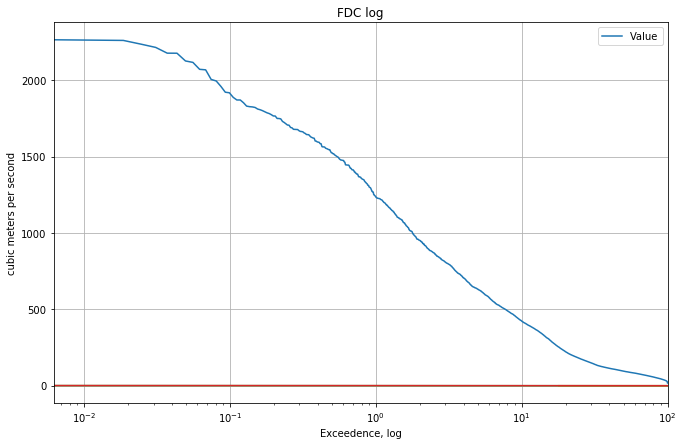

In [2]:
#What are the latitudes and longtitudes of the area you want to make a picture of?
lat = -34.71966901
lon = 143.1698626
buffer = 8000
#Where abouts is your csv file located on your computer?
csv_file_location = '/g/data/r78/kd6095/dea-notebooks/Boundary_Bend/Murray_River_Boundary_Bend.csv'

#Loading and organising guage data
gauge_data = pd.read_csv(csv_file_location,
                error_bad_lines = False, skiprows=9, escapechar='#', 
                         parse_dates=['Timestamp'], #Tells it this column is date format
                         index_col=('Timestamp'),
                        date_parser=lambda x: pd.to_datetime(x.rsplit('+', 1)[0]))
gauge_data = gauge_data.dropna()
gauge_data = gauge_data.sort_values('Value')
gauge_data['rownumber'] = np.arange(len(gauge_data))
gauge_data['Exceedence'] = (1-(gauge_data.rownumber/len(gauge_data)))*100
gauge_data = gauge_data.drop(columns='Interpolation Type')
gauge_data = gauge_data.drop(columns='Quality Code')

#fig, ax = plt.subplots(ncols=2, figsize=(10, 5))

gauge_data.plot(x='Exceedence', y='Value', figsize=(11,7))#ax=ax[0])
plt.ylabel('cubic meters per second')
plt.grid(True)
plt.title('FDC')

gauge_data.plot(x='Exceedence', y='Value', figsize=(11,7)) #ax=ax[1])
plt.ylabel('cubic meters per second')
plt.xlabel('Exceedence, log')
plt.semilogx(gauge_data, np.exp(-gauge_data/5.0))
plt.grid(True)
plt.title('FDC log')

# Select range of flow / water level to analyse

In [3]:
#What part of the Flow Duration Curve do you want to look at?
yaxis_lower_parameter = 500
yaxis_higher_parameter = 2500

gauge_data_xr = gauge_data.to_xarray()

#Dask loading wofs_albers data
x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query = {'x': (x - buffer, x + buffer),
         'y': (y - buffer, y + buffer),    
         'time': ('1988-01-01', '2019-08-22'), 
         'crs': 'EPSG:3577'} 
dc = datacube.Datacube(app='dc-WOfS')
wofs_albers= dc.load(product = 'wofs_albers', dask_chunks = {}, group_by='solar_day', **query)

merged_data = gauge_data_xr.interp(Timestamp=wofs_albers.time)

specified_level = merged_data.where((merged_data.Value > yaxis_lower_parameter) & 
                                    (merged_data.Value < yaxis_higher_parameter), drop=True)
date_list = specified_level.time.values

specified_level.time

<xarray.DataArray 'time' (time: 92)>
array(['1989-05-30T23:43:19.500000000', '1989-07-01T23:42:40.500000000',
       '1989-07-17T23:42:19.500000000', '1989-07-24T23:48:22.500000000',
       '1989-08-09T23:48:01.500000000', '1989-09-03T23:41:19.000000000',
       '1989-09-10T23:47:14.500000000', '1989-09-19T23:40:46.500000000',
       '1989-09-26T23:46:55.500000000', '1989-10-05T23:40:36.500000000',
       '1989-10-12T23:46:27.500000000', '1990-08-12T23:41:10.500000000',
       '1990-09-06T23:34:49.500000000', '1990-09-13T23:41:02.500000000',
       '1990-09-22T23:34:47.500000000', '1990-09-29T23:40:51.500000000',
       '1990-10-08T23:34:36.500000000', '1990-10-24T23:34:32.500000000',
       '1991-10-11T23:39:06.500000000', '1991-10-27T23:39:09.500000000',
       '1992-10-20T23:42:39.500000000', '1992-11-05T23:42:23.500000000',
       '1992-11-14T23:36:02.500000000', '1992-11-30T23:36:08.500000000',
       '1993-01-01T23:36:28.500000000', '1993-01-08T23:42:45.500000000',
       '1993-0

# Load data and cloud mask

In [4]:
x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query = {'x': (x - buffer, x + buffer),
         'y': (y - buffer, y + buffer), 
         'crs': 'EPSG:3577'} 

#loop selecting data based on FDC parameters
xr_list = []
for date in date_list:
    date = str(date)  
    wofs_albers= dc.load(product = 'wofs_albers', time=date,  **query)
    xr_list.append(wofs_albers)
specified_passes = xr.concat(xr_list, dim='time')

#Cloud Mask
ClearTimesteps = []
for ix, timestep in enumerate(specified_passes.time):
    SingleTime = specified_passes.water.isel(time=ix)
    IsItCloudy = masking.make_mask(SingleTime, cloud=True)
    CountClouds = IsItCloudy.sum()   
    PercentCloudy = CountClouds.values.item()/(len(specified_passes.x)*len(specified_passes*y))*100
    IsItClearEnough = PercentCloudy <= 50  
    if IsItClearEnough:
        ClearTimesteps.append(ix)     
clear_specified_passes = specified_passes.water.isel(time = ClearTimesteps)

wet = (clear_specified_passes == 128).sum(dim='time')
dry = (clear_specified_passes == 0).sum(dim='time')
clear = wet + dry
frequency = wet / clear
frequency= frequency.fillna(0) #this is to get rid of the NAs that occur due to mountain shadows
frequency = frequency.where(frequency!=0) #This is to tell it to make areas that were dry 100% of the time white

clear_specified_passes.time

<xarray.DataArray 'time' (time: 44)>
array(['1989-05-30T23:43:19.500000000', '1989-07-01T23:42:40.500000000',
       '1989-07-24T23:48:22.500000000', '1989-09-03T23:41:19.000000000',
       '1989-09-19T23:40:46.500000000', '1989-09-26T23:46:55.500000000',
       '1989-10-05T23:40:36.500000000', '1989-10-12T23:46:27.500000000',
       '1990-08-12T23:41:10.500000000', '1990-09-13T23:41:02.500000000',
       '1990-09-22T23:34:47.500000000', '1990-09-29T23:40:51.500000000',
       '1990-10-24T23:34:32.500000000', '1991-10-11T23:39:06.500000000',
       '1992-10-20T23:42:39.500000000', '1992-11-30T23:36:08.500000000',
       '1993-01-01T23:36:28.500000000', '1993-01-08T23:42:45.500000000',
       '1993-10-07T23:43:26.500000000', '1993-10-16T23:37:11.500000000',
       '1993-11-08T23:43:12.500000000', '1993-11-17T23:36:54.500000000',
       '1993-11-24T23:43:05.500000000', '1995-09-04T23:17:28.500000000',
       '1996-11-25T23:36:18.500000000', '1996-12-02T23:42:49.500000000',
       '2010-1

# Generate image of specified flow / water level range

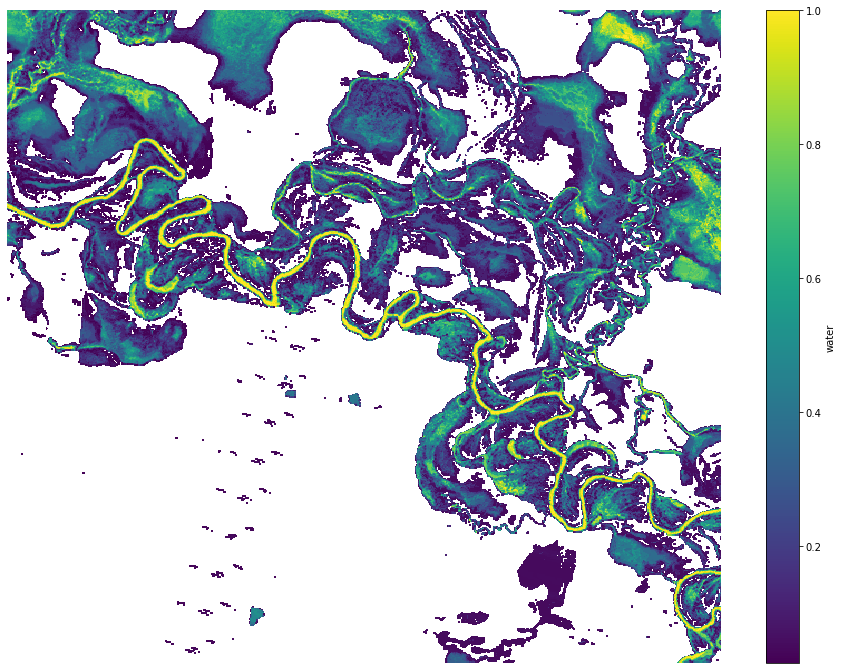

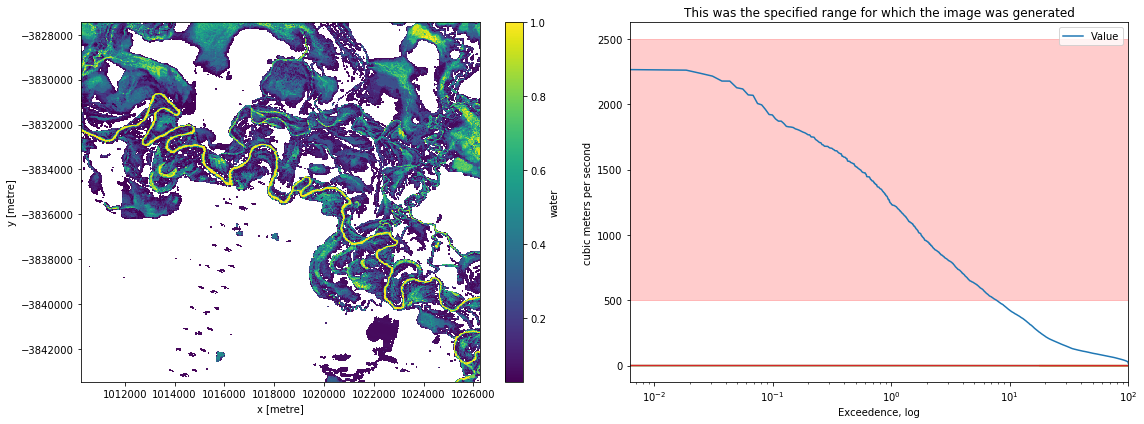

In [5]:
frequency.plot(figsize = (16, 12))
plt.axis('off')

fig, ax = plt.subplots(ncols=2, figsize=(16, 6))

ax1 = frequency.plot(ax=ax[0])

ax2 = gauge_data.plot(x='Exceedence', y='Value', ax=ax[1]) 
ax2 = plt.axhspan(yaxis_lower_parameter, yaxis_higher_parameter, color='red', alpha=0.2)
ax2 = plt.title('This was the specified range for which the image was generated')
ax2 = plt.ylabel('cubic meters per second')
ax2 = plt.xlabel('Exceedence, log')
ax2 = plt.semilogx(gauge_data, np.exp(-gauge_data/5.0))


plt.tight_layout()